Setup Simulation
----------------

Import needed libraries and define constants

In [1]:
# Imports
from rcfdtd_sim import Sim, Current, Mat, vis
import numpy as np
from scipy.fftpack import fft
from matplotlib import pyplot as plt
from pathlib import Path
# Determine file save name
fsave = 'dat1_1ps.npz'
# Constants
c0 = 300 # um/ps
di = 0.003 # 0.003 um
dn = di/c0 # (0.003 um) / (300 um/ps) = 0.00001 ps = 0.01 fs
epsilon0 = 8.85419e18 # (A^2 ps^4)/(kg um^3)
mu0 = 1.25664e-24 # (kg um)/(A^2 ps^2)

Define simulation bounds and calculate length in indicies

In [2]:
# Define bounds
i0 = -3 # -3um
i1 = 6 # 6 um
n0 = -1e-2 # -1e-3 ps = -10 fs
n1 = 1 # 1 ps = 1000 fs
# Calculate dimensions
nlen, ilen = Sim.calc_dims(n0, n1, dn, i0, i1, di)

Create our time and space arrays to help construct our material and current pulse

In [3]:
# Create a arrays that hold the value of the center of each cell
t = np.linspace(n0+dn/2, n1+dn/2, nlen, endpoint=False)
z = np.linspace(i0+di/2, i1+di/2, ilen, endpoint=False)

Setup Current
-------------

Specify the location of our current pulse in time and space

In [4]:
cp_loc_val = -2
cp_time_val = 0

Determine the simulation indicies that correspond to these locations

In [5]:
# Find indicies
cp_loc_ind = np.argmin(np.abs(np.subtract(z, cp_loc_val)))
cp_time_ind = np.argmin(np.abs(np.subtract(t, cp_time_val)))
# Find start and end indicies in time
cp_time_s = cp_time_ind - 350
cp_time_e = cp_time_ind + 350

Create the current pulse

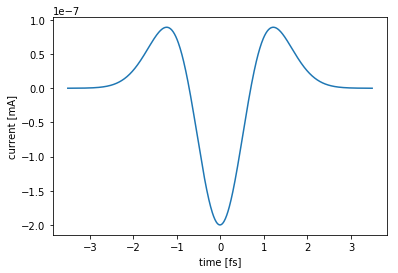

In [6]:
# Make pulse
cpulse = np.append(np.diff(np.diff(np.exp(-((t[cp_time_s:cp_time_e]-cp_time_val)**2)/(1e-6)))), [0,0])
# Plot
plt.plot(1e3*t[cp_time_s:cp_time_e], 1e-3*cpulse) # 1e3 scale factor converts from ps -> fs, and 1e-3 scale factor converts from A -> mA
plt.xlabel('time [fs]')
plt.ylabel('current [mA]')
plt.show()
# Create Current object
current = Current(nlen, ilen, cp_time_s, cp_loc_ind, cpulse)

Setup Material
--------------

Specify the location of our material (which will be $4$um in length)

In [7]:
# Set material length
m_len = 4 # 4 um
# Set locations
m_s_val = 0
m_e_val = m_s_val + m_len

Calculate the starting and ending indicies of our material

In [8]:
m_s_ind = np.argmin(np.abs(np.subtract(z, m_s_val)))
m_e_ind = np.argmin(np.abs(np.subtract(z, m_e_val)))

Setup material behavior

In [9]:
# Set constants
gamma = np.complex64(0.01 * 2 * np.pi)
omega = np.complex64(0.0)
a1 = np.complex64(0)
a2 = np.complex64(0)
# Calculate beta
beta = np.sqrt(np.add(np.square(gamma), -np.square(omega)))

Create our material behavior matrices

In [10]:
# Determine matrix length
mlen = m_e_ind - m_s_ind
# Create matrices
m = np.ones((1, mlen), dtype=np.complex64)
mgamma = m * gamma
mbeta = m * beta
ma1 = m * a1
ma2 = m * a2

Create our material object

In [11]:
inf_perm = 8
material = Mat(dn, ilen, m_s_ind, inf_perm, ma1, ma2, mgamma, mbeta)

Running the Simulation
----------------------

Create and run our simulation (or load simulation if one already exists)

In [12]:
# Create Sim object
s = Sim(i0, i1, di, n0, n1, dn, epsilon0, mu0, 'absorbing', current, material, nstore=int(nlen/20), storelocs=[1,ilen-2])
# Run simulation if simulation save doesn't exist
sim_file = Path(fsave)
if sim_file.is_file():
    # Load results
    dat = np.load(fsave)
    n = dat['n']
    ls = dat['ls']
    els = dat['els']
    erls = dat['erls']
    hls = dat['hls']
    hrls = dat['hrls']
else:
    # Run simulation
    s.simulate()
    # Export and save arrays
    n, ls, els, erls, hls, hrls = s.export_locs()
    np.savez(fsave, n=n, ls=ls, els=els, erls=erls, hls=hls, hrls=hrls)

Finding the Transmission and Reflection Coefficients
----------------------------------------------------

We ultimately wish to calculate the reflection and transmission coefficients
$$R(\omega)=\frac{E_r(\omega)}{E_i(\omega)} \qquad T(\omega)=\frac{E_t(\omega)}{E_i(\omega)}$$
which means that we need to extract our incident E-field $E_i$, reflected E-field $E_r$, and transmitted E-field $E_t$ from our E-field and reference E-field passing through $i=1$ and $i=\text{ilen}-2$ (these fields are contained in `els` and `erls`). The incident E-field $E_i$ should be equal to the reference E-field passing through $i=\text{ilen}-2$. Since the current is only non-zero from $-3$fs to $3$fs and since it will take light propegating at $300$um/ps $26.6$fs to reach the end of the simulation at $6$um from $-2$um, we plot the reference E-field from $23.6$fs to $29.6$fs below

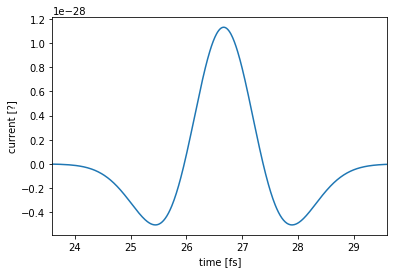

In [13]:
# Plot the E-field passing through i=ilen-2
inc = erls[:,1] # Extract the transmitted reference E-field as the incident field
plt.plot(1e3*n, np.real(inc)) # 1e3 scale factor converts from ps -> fs
plt.ylabel('current [?]')
plt.xlabel('time [fs]')
# Lets zoom in on the x-axis as described above
plt.xlim(23.6,29.6)
plt.show()

The pulse is (roughly) centered as expected. We can extract $E_i(\omega)$ from $E^{i=\text{ilen}-2}_\text{ref}(t)$ via
$$\mathcal{F}\left\{E^{i=\text{ilen}-2}_\text{ref}(t)\right\}=E_i(\omega)$$
where $\mathcal{F}\left\{A(t)\right\}=A(\omega)$ denotes a Fourier Transform on $A$

In [14]:
# Perform FFT
incf = fft(inc)
# Discard negative frequencies (at nlen/2 and above), keep DC (at 0)
incf = incf[0:int(nlen/2)]
# Determine the frequency that each value in eef corresponds to
nf = np.linspace(0, 1/(2*dn), int(nlen/2))

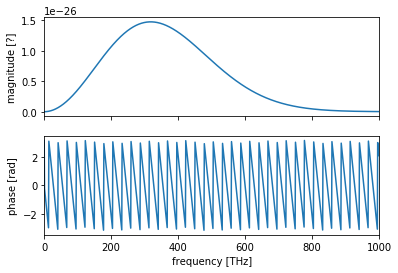

In [15]:
# Plot
fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True)
ax0.plot(nf, np.absolute(incf))
ax0.set_ylabel('magnitude [?]')
ax1.plot(nf, np.angle(incf))
ax1.set_ylabel('phase [rad]')
plt.xlabel('frequency [THz]')
plt.xlim(0,1000) # Truncate at 1THz
plt.show()

We can determine the transmitted E-field $E_t$ from the E-field passing through $i=\text{ilen}-2$. We plot this field below

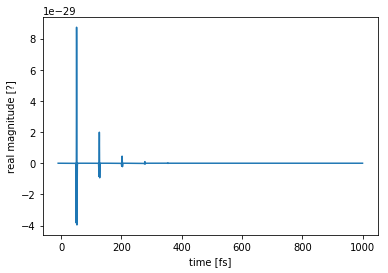

In [16]:
# Plot the E-field passing through i=ilen-2
trans = els[:,1] # Extract the E-field as the transmitted field
plt.plot(1e3*n, np.real(trans)) # 1e3 scale factor converts from ps -> fs
plt.ylabel('real magnitude [?]')
plt.xlabel('time [fs]')
plt.show()

Since there will be an infinite number of reflections inside of the material, we will never capture the entire transmitted E-field. However, if we run the simulation for a long enough time the E-field remaining in the material will become negligable. We extract $E_t(\omega)$ via
$$\mathcal{F}\left\{E^{i=\text{ilen}-2}(t)\right\}=E_t(\omega)$$
where again $\mathcal{F}\left\{A(t)\right\}=A(\omega)$ denotes a Fourier Transform on $A$

In [17]:
# Perform FFT
transf = fft(trans)
# Discard negative frequencies (at nlen/2 and above), keep DC (at 0)
transf = transf[0:int(nlen/2)]

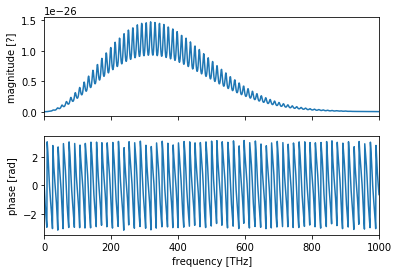

In [18]:
# Plot
fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True)
ax0.plot(nf, np.absolute(transf))
ax0.set_ylabel('magnitude [?]')
ax1.plot(nf, np.angle(transf))
ax1.set_ylabel('phase [rad]')
plt.xlabel('frequency [THz]')
plt.xlim(0,1000) # Truncate at 1THz
plt.show()

Now all that remains is to determine the reflected E-field $E_r(\omega)$. This field is slightly harder to calculate than $E_i$ and $E_t$ as the current pulse that generates the EM pulse in the simulation actually produces two EM pulses, one traveling towards each end of the simulation. The forward propegating pulse is our incident pulse (we used this to calculate $E_i(\omega)$ previously), while the backward propegating pulse is unwanted. Since the reference field never interacts with a material, $E^{i=1}_\text{ref}(t)$ will only contain the backward propegating pulse. As such, we can determine the reflected field $E_r(t)$ from
$$E_r(t)=E^{i=1}(t)-E^{i=1}_\text{ref}(t)$$
As in the case of determining the transmitted field $E_t$ we can never capture the entire transmitted E-field as there will be an infinite number of reflections inside the material. However, as before, if we run the simulation for a long enough time the E-field remaining in the material will become negligable.

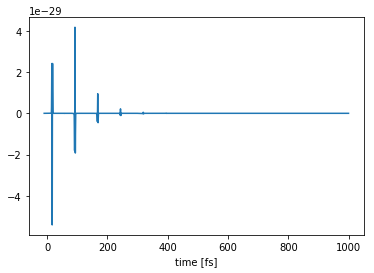

In [19]:
# Plot the reflected E-field passing through i=1
r = els[:,0] # Extract the transmitted E-field
rref = erls[:,0]
refl = r - rref
plt.plot(1e3*n, np.real(refl)) # 1e3 scale factor converts from ps -> fs
plt.xlabel('time [fs]')
plt.show()

We extract $E_t(\omega)$ via a Fourier transform as usual
$$\mathcal{F}\left\{E_r(t)\right\}=E_r(\omega)$$
where again $\mathcal{F}\left\{A(t)\right\}=A(\omega)$ denotes a Fourier Transform on $A$

In [20]:
# Perform FFT
reflf = fft(refl)
# Discard negative frequencies (at nlen/2 and above), keep DC (at 0)
reflf = reflf[0:int(nlen/2)]

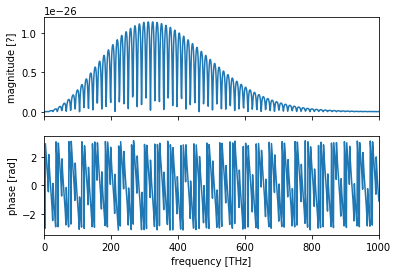

In [21]:
# Plot
fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True)
ax0.plot(nf, np.absolute(reflf))
ax0.set_ylabel('magnitude [?]')
ax1.plot(nf, np.angle(reflf))
ax1.set_ylabel('phase [rad]')
plt.xlabel('frequency [THz]')
plt.xlim(0,1000) # Truncate at 1THz
plt.show()

We can now finally calculate
$$R(\omega)=\frac{E_r(\omega)}{E_i(\omega)} \qquad T(\omega)=\frac{E_t(\omega)}{E_i(\omega)}$$

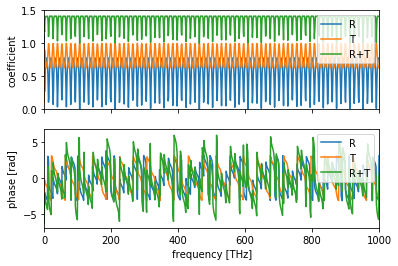

In [22]:
# Calculate coefficients
R = np.divide(reflf, incf)
T = np.divide(transf, incf)
# Plot
fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True)
ax0.plot(nf, np.absolute(R), label='R')
ax0.plot(nf, np.absolute(T), label='T')
ax0.plot(nf, np.absolute(R)+np.absolute(T), label='R+T')
ax0.set_ylim(0,1.5)
ax0.legend(loc=1)
ax0.set_ylabel('coefficient')
ax1.plot(nf, np.angle(R), label='R')
ax1.plot(nf, np.angle(T), label='T')
ax1.plot(nf, np.angle(R)+np.angle(T), label='R+T')
ax1.legend(loc=1)
ax1.set_ylabel('phase [rad]')
ax1.set_xlabel('frequency [THz]')
ax1.set_xlim(0, 1000) # Truncate at 1THz
plt.show()

There is a clear Fabry-Perot effect present in the material transmission. Notably $R(\omega)+T(\omega)\neq1$, which suggests values are being incorrectly normalized somewhere in the simulation. Hopefully further investigation will determine the cause of this issue.